<a href="https://colab.research.google.com/github/aquibjaved/Bits_and_Pieces_DL/blob/main/Basics_of_lora_implementation_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import torch.nn.utils.parametrize as P
from sklearn.datasets import load_iris
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
# Define a transform to normalize the data and flatten each image into a 1D array
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x.view(-1))
])

def collate_fn(batch):
    data, target = zip(*batch)
    data = torch.stack(data)
    target = torch.tensor(target)
    return data.cuda(), target.cuda()

In [3]:
def plot_flattened_images(flattened_images, labels, img_shape, class_names, num_images=5):
    """
    Plots images that have been flattened.

    Parameters:
        flattened_images (torch.Tensor): The flattened images tensor.
        labels (torch.Tensor): The labels tensor.
        img_shape (tuple): The original shape of the images (e.g., (28, 28) for Fashion MNIST).
        class_names (list): List of class names.
        num_images (int): Number of images to plot.
    """
    # Reshape the flattened images back to their original shape
    reshaped_images = flattened_images.view(-1, *img_shape).numpy()

    # Create a figure and axes
    fig, axes = plt.subplots(1, num_images, figsize=(10, 5))

    for i, ax in enumerate(axes):
        img = reshaped_images[i]
        label = class_names[labels[i].item()]
        ax.imshow(img, cmap='gray')
        ax.set_title(label)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [4]:
train_dataset = datasets.FashionMNIST('~/.data', download=True, train=True, transform=transform)
test_dataset = datasets.FashionMNIST('~/.data', download=True, train=False, transform=transform)

100%|██████████| 26421880/26421880 [00:01<00:00, 21069547.83it/s]


Extracting /root/.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 411135.26it/s]


Extracting /root/.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6189797.02it/s]


Extracting /root/.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 17413126.61it/s]


Extracting /root/.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.data/FashionMNIST/raw



In [5]:
def split_dataset(dataset, labels):
    indices = [i for i, (data, label) in enumerate(dataset) if label in labels]
    return torch.utils.data.Subset(dataset, indices)

labels_1 = [0, 1, 2, 3, 4]
labels_2 = [5, 6, 7, 8, 9]

train_dataset_04 = split_dataset(train_dataset, labels_1)
train_dataset_59 = split_dataset(train_dataset, labels_2)

batch_size = 64

train_loader_1 = torch.utils.data.DataLoader(train_dataset_04, batch_size=batch_size, shuffle=True)
train_loader_2 = torch.utils.data.DataLoader(train_dataset_59, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

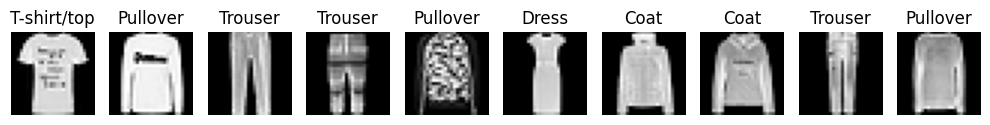

In [6]:
# Get one batch of images and labels
dataiter = iter(train_loader_1)
images, labels = next(dataiter)

# Define the class names for Fashion MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plot_flattened_images(flattened_images=images, labels=labels, img_shape=(28,28), num_images=10, class_names=class_names)

In [7]:
class FashionNet(nn.Module):
  def __init__(self, input_dims, num_class, input_hidden_size: 1000, hidden_layer_size:2000):

    super().__init__()
    self.input_dims = input_dims
    self.num_class = num_class

    self.input_layer = nn.Linear(in_features=self.input_dims, out_features=1000)
    self.hidden_layer = nn.Linear(in_features=1000, out_features=2000)
    self.output_layer = nn.Linear(in_features=2000, out_features=self.num_class)

  def forward(self, x):
    out = F.relu(self.input_layer(x))
    out = F.relu(self.hidden_layer(out))
    out = self.output_layer(out)
    return out

In [8]:
# Check for GPU availability
cuda_available = torch.cuda.is_available()

In [17]:
import torch

def train_model(epochs:int, train_loader, model, optimizer, criterion):
  model.train()
  train_loss_per_epoch = []

  for epoch in range(epochs):

    running_loss_train = 0.0

    for data_batch, target_batch in train_loader:

        data_batch = data_batch.to('cpu')
        target_batch = target_batch.to('cpu')

        optimizer.zero_grad()
        output = model(data_batch)
        loss_train = criterion(output, target_batch)
        loss_train.backward()
        optimizer.step()
        running_loss_train += loss_train.item()

    epcoh_loss_train = running_loss_train / len(train_loader)

    train_loss_per_epoch.append(epcoh_loss_train)


    if epoch %2 == 0:
      print(f'Epoch {epoch} Train loss {epcoh_loss_train}')
  return train_loss_per_epoch

device='cpu'

import torch
from sklearn.metrics import confusion_matrix
import numpy as np

def test(test_loader, net):
    correct = 0
    total = 0

    wrong_counts = [0 for i in range(10)]

    with torch.no_grad():
        for data in test_loader:
            x, y = data
            x = x.to(device)
            y = y.to(device)
            output = net(x)
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                    correct +=1
                else:
                    wrong_counts[y[idx]] +=1
                total +=1
    print(f'Accuracy: {round(correct/total, 3)}')
    for i in range(len(wrong_counts)):
        print(f'wrong counts for the Label {i}: {wrong_counts[i]}')



In [10]:
BigNet = FashionNet(input_dims=784, num_class=len(class_names), input_hidden_size=1000, hidden_layer_size=2000)
optimizer = optim.SGD(BigNet.parameters(), lr=0.0001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Assume `model` is your model
if cuda_available:
    BigNet = BigNet.to('cuda')
    optimizer = optim.SGD(BigNet.parameters(), lr=0.011, momentum=0.9)
    criterion = nn.CrossEntropyLoss().to('cuda')

is_on_gpu = next(BigNet.parameters()).is_cuda
print(f'Model is on GPU: {is_on_gpu}')

trainable_params = sum(p.numel() for p in BigNet.parameters() if p.requires_grad)
print(f'Number of trainable (tunable) parameters: {trainable_params}')

Model is on GPU: False
Number of trainable (tunable) parameters: 2807010


In [14]:
trainLoss = train_model(epochs=2,
                        train_loader=train_loader_1,
                        optimizer = optimizer,
                        criterion=criterion,
                        model=BigNet,
                        )

Epoch 0 Train loss 0.639518587701102


In [15]:
torch.save(BigNet.state_dict(), 'model.pt')

In [18]:
# Call the function
test(
      test_loader=test_loader,
      net=BigNet,
)

original_weights = {}
for name, param in BigNet.named_parameters():
    original_weights[name] = param.clone().detach()

Accuracy: 0.403
wrong counts for the Label 0: 162
wrong counts for the Label 1: 86
wrong counts for the Label 2: 266
wrong counts for the Label 3: 152
wrong counts for the Label 4: 306
wrong counts for the Label 5: 1000
wrong counts for the Label 6: 1000
wrong counts for the Label 7: 1000
wrong counts for the Label 8: 1000
wrong counts for the Label 9: 1000


In [ ]:
# Load the model and test it
model = FashionNet(input_dims=784, num_class=len(class_names), input_hidden_size=1000, hidden_layer_size=2000)
model.load_state_dict(torch.load('model.pt'))
model.to('cuda')
# Call the function
test(
      test_loader=test_loader,
      net=model,
)

Accuracy: 0.456
wrong counts for the Label 0: 31
wrong counts for the Label 1: 24
wrong counts for the Label 2: 143
wrong counts for the Label 3: 100
wrong counts for the Label 4: 143
wrong counts for the Label 5: 1000
wrong counts for the Label 6: 1000
wrong counts for the Label 7: 1000
wrong counts for the Label 8: 1000
wrong counts for the Label 9: 1000


In [ ]:
total_parameters_original = 0
for index, layer in enumerate([BigNet.input_layer, BigNet.hidden_layer, BigNet.output_layer]):
    total_parameters_original += layer.weight.nelement() + layer.bias.nelement()
    print(f'Layer {index+1}: W: {layer.weight.shape} + B: {layer.bias.shape}')
print(f'Total number of parameters: {total_parameters_original:,}')

Layer 1: W: torch.Size([1000, 784]) + B: torch.Size([1000])
Layer 2: W: torch.Size([2000, 1000]) + B: torch.Size([2000])
Layer 3: W: torch.Size([10, 2000]) + B: torch.Size([10])
Total number of parameters: 2,807,010


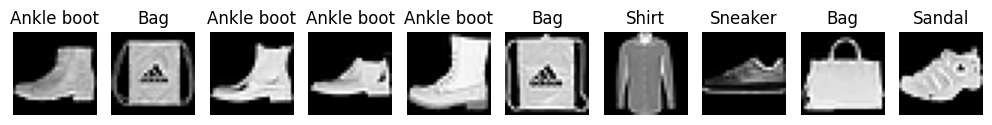

In [ ]:
# Get one batch of images and labels
dataiter = iter(train_loader_2)
images, labels = next(dataiter)

# Define the class names for Fashion MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plot_flattened_images(flattened_images=images, labels=labels, img_shape=(28,28), num_images=10, class_names=class_names)

In [29]:
class LoRaModel(nn.Module):
  def __init__(self, r: int, alpha_lora: int, input_dims: int, input_hidden_size: 1000, hidden_layer_size:2000, num_class:int):
    super().__init__()
    self.r = r
    self.alpha_lora = alpha_lora
    self.input_dims = input_dims
    self.input_hidden_size = input_hidden_size
    self.hidden_layer_size = hidden_layer_size
    self.num_class = num_class

    self.input_layer = nn.Linear(in_features=self.input_dims, out_features=self.input_hidden_size)
    self.input_layer.weight.requires_grad = False

    self.hidden_layer = nn.Linear(in_features=self.input_hidden_size, out_features=self.hidden_layer_size)
    self.hidden_layer.weight.requires_grad = False

    self.output_layer = nn.Linear(in_features=self.hidden_layer_size, out_features=self.num_class)
    self.output_layer.weight.requires_grad = False


    self.input_lora_A = nn.Linear(self.input_dims, self.r)
    self.input_lora_B = nn.Linear(self.r, self.input_hidden_size)

    self.hidden_lora_A = nn.Linear(self.input_hidden_size, self.r)
    self.hidden_lora_B = nn.Linear(self.r, self.hidden_layer_size)

    self.output_lora_A = nn.Linear(self.hidden_layer_size, self.r)
    self.output_lora_B = nn.Linear(self.r, self.num_class)

    self.dropout = nn.Dropout(0.1)
    self.scaling = self.alpha_lora / self.r

    for n,p in self.named_parameters():
      if 'lora' in n:
          if n[-1]=='A':
              nn.init.kaiming_normal_(p, a=math.sqrt(5))
          elif n[-1]=='B':
              nn.init.zeros_(p)

    # freeze non lora weights
    for n,p in self.named_parameters():
        if 'lora' not in n:
            p.requires_grad = False
        else:
            p.requires_grad = True



  def forward(self, x):

    ou_pretrain = F.relu(self.input_layer(x))
    ou_pretrain = F.relu(self.hidden_layer(ou_pretrain))
    ou_pretrain = self.output_layer(ou_pretrain)

    lora_out_input = self.input_lora_A(x)
    lora_out_input = self.input_lora_B(lora_out_input)

    lora_out_hidden = self.hidden_lora_A(lora_out_input)
    lora_out_hidden = self.hidden_lora_B(lora_out_hidden)

    lora_out_output = self.output_lora_A(lora_out_hidden)
    lora_out_output = self.output_lora_B(lora_out_output)

    lora_out = lora_out_output * self.scaling



    return ou_pretrain+lora_out


In [30]:
lora_model = LoRaModel(r=2, alpha_lora=1, input_dims=784,input_hidden_size=1000, hidden_layer_size=2000, num_class=10)
lora_model.load_state_dict(torch.load('model.pt'), strict=False)


_IncompatibleKeys(missing_keys=['input_lora_A.weight', 'input_lora_A.bias', 'input_lora_B.weight', 'input_lora_B.bias', 'hidden_lora_A.weight', 'hidden_lora_A.bias', 'hidden_lora_B.weight', 'hidden_lora_B.bias', 'output_lora_A.weight', 'output_lora_A.bias', 'output_lora_B.weight', 'output_lora_B.bias'], unexpected_keys=[])

In [31]:
for name, param in lora_model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.shape}")

trainable_params = sum(p.numel() for p in lora_model.parameters() if p.requires_grad)
print(f'Number of trainable (tunable) parameters: {trainable_params}')

input_lora_A.weight: torch.Size([2, 784])
input_lora_A.bias: torch.Size([2])
input_lora_B.weight: torch.Size([1000, 2])
input_lora_B.bias: torch.Size([1000])
hidden_lora_A.weight: torch.Size([2, 1000])
hidden_lora_A.bias: torch.Size([2])
hidden_lora_B.weight: torch.Size([2000, 2])
hidden_lora_B.bias: torch.Size([2000])
output_lora_A.weight: torch.Size([2, 2000])
output_lora_A.bias: torch.Size([2])
output_lora_B.weight: torch.Size([10, 2])
output_lora_B.bias: torch.Size([10])
Number of trainable (tunable) parameters: 16604


In [34]:
lora_model.to('cpu')

trainLoss = train_model(epochs=2,
                        train_loader=train_loader_2,
                        optimizer = optimizer,
                        criterion=criterion,
                        model=lora_model,
                        )

# lora_model.load_state_dict(torch.load('model.pt'), strict=False)

test(
      test_loader=test_loader,
      net=lora_model,
)

Epoch 0 Train loss 6.483939028497952
Accuracy: 0.389
wrong counts for the Label 0: 191
wrong counts for the Label 1: 91
wrong counts for the Label 2: 141
wrong counts for the Label 3: 126
wrong counts for the Label 4: 566
wrong counts for the Label 5: 1000
wrong counts for the Label 6: 1000
wrong counts for the Label 7: 1000
wrong counts for the Label 8: 1000
wrong counts for the Label 9: 1000


In [35]:
for names, param in lora_model.named_parameters():
  print(names, param)

input_layer.weight Parameter containing:
tensor([[ 0.0160, -0.0182,  0.0336,  ..., -0.0029, -0.0324,  0.0112],
        [-0.0035,  0.0099,  0.0242,  ...,  0.0161, -0.0093, -0.0090],
        [ 0.0237,  0.0043, -0.0035,  ...,  0.0010, -0.0015,  0.0059],
        ...,
        [-0.0018,  0.0215, -0.0288,  ...,  0.0004,  0.0312,  0.0018],
        [ 0.0038, -0.0142, -0.0025,  ..., -0.0359, -0.0182, -0.0110],
        [-0.0003,  0.0188,  0.0107,  ..., -0.0099, -0.0153, -0.0135]])
input_layer.bias Parameter containing:
tensor([ 5.1296e-03,  1.2252e-03,  1.2655e-02,  1.8911e-02, -1.4028e-02,
         4.2606e-04, -3.0085e-02,  1.5552e-02,  3.2757e-02, -1.7161e-02,
        -2.2805e-02,  3.5897e-03,  1.9559e-02,  2.2157e-02,  1.2334e-02,
         1.2101e-02,  2.4942e-02,  3.3231e-02, -1.3623e-02, -2.6888e-02,
        -1.7427e-02, -2.0777e-02, -3.1968e-02,  4.0514e-03, -1.8202e-02,
         2.5753e-02,  3.1227e-02,  2.6633e-02, -7.9401e-03,  2.2776e-02,
         1.5033e-05,  2.5773e-02,  3.2761e-02, -

In [ ]:
total_parameters_lora = 0
total_parameters_non_lora = 0
for index, layer in enumerate([BigNet.input_layer, BigNet.hidden_layer, BigNet.output_layer]):
    total_parameters_lora += layer.parametrizations["weight"][0].lora_A.nelement() + layer.parametrizations["weight"][0].lora_B.nelement()
    total_parameters_non_lora += layer.weight.nelement() + layer.bias.nelement()
    print(
        f'Layer {index+1}: W: {layer.weight.shape} + B: {layer.bias.shape} + Lora_A: {layer.parametrizations["weight"][0].lora_A.shape} + Lora_B: {layer.parametrizations["weight"][0].lora_B.shape}'
    )
# The non-LoRA parameters count must match the original network
assert total_parameters_non_lora == total_parameters_original
print(f'Total number of parameters (original): {total_parameters_non_lora:,}')
print(f'Total number of parameters (original + LoRA): {total_parameters_lora + total_parameters_non_lora:,}')
print(f'Parameters introduced by LoRA: {total_parameters_lora:,}')
parameters_incremment = (total_parameters_lora / total_parameters_non_lora) * 100
print(f'Parameters incremment: {parameters_incremment:.3f}%')

Layer 1: W: torch.Size([1000, 784]) + B: torch.Size([1000]) + Lora_A: torch.Size([8, 784]) + Lora_B: torch.Size([1000, 8])
Layer 2: W: torch.Size([2000, 1000]) + B: torch.Size([2000]) + Lora_A: torch.Size([8, 1000]) + Lora_B: torch.Size([2000, 8])
Layer 3: W: torch.Size([10, 2000]) + B: torch.Size([10]) + Lora_A: torch.Size([8, 2000]) + Lora_B: torch.Size([10, 8])
Total number of parameters (original): 2,807,010
Total number of parameters (original + LoRA): 2,861,362
Parameters introduced by LoRA: 54,352
Parameters incremment: 1.936%


In [ ]:
# Check that the frozen parameters are still unchanged by the finetuning
assert torch.all(BigNet.input_layer.parametrizations.weight.original == original_weights['input_layer.weight'])
assert torch.all(BigNet.hidden_layer.parametrizations.weight.original == original_weights['hidden_layer.weight'])
assert torch.all(BigNet.output_layer.parametrizations.weight.original == original_weights['output_layer.weight'])

enable_disable_lora(enabled=True)
# The new linear1.weight is obtained by the "forward" function of our LoRA parametrization
# The original weights have been moved to net.linear1.parametrizations.weight.original
# More info here: https://pytorch.org/tutorials/intermediate/parametrizations.html#inspecting-a-parametrized-module
assert torch.equal(BigNet.input_layer.weight, BigNet.input_layer.parametrizations.weight.original + (BigNet.input_layer.parametrizations.weight[0].lora_B @ BigNet.input_layer.parametrizations.weight[0].lora_A) * BigNet.input_layer.parametrizations.weight[0].scale)

enable_disable_lora(enabled=False)
# If we disable LoRA, the linear1.weight is the original one
assert torch.equal(BigNet.input_layer.weight, original_weights['input_layer.weight'])

AssertionError: ignored

In [ ]:
# Test with LoRA enabled
enable_disable_lora(enabled=True)
test(
      test_loader=test_loader,
      net=BigNet,
)

In [ ]:
enable_disable_lora(enabled=False)

weights_with_lora = {}
for name, parm in BigNet.named_parameters():
  weights_with_lora[param] = parm.clone().detach()


In [ ]:
weights_with_lora